In [1]:
import ROOT
import os
import nbimporter
import utils
import ctypes
import pandas as pd
from numpy import arange
from pprint import pprint

Welcome to JupyROOT 6.30/02


In [2]:
outputFolder = 'plots/'
grafana_table_csv = '../data/grafana_efficiency_table.csv'
runs = utils.get_completed_runs_longer_than(grafana_table_csv,50)
rad_eff_file_pattern = '/eos/cms/store/group/dpg_ctpps/comm_ctpps/pps-automation/dev/pps-test-re-tracking-efficiency/test_efficiency_era/pps-test-re-tracking-efficiency/{run}/outputTrackingEfficiency_run{run}.root'
track_dist_file_pattern = '/eos/cms/store/group/dpg_ctpps/comm_ctpps/pps-automation/dev/pps-test-re-tracking-efficiency/test_efficiency_era/pps-test-re-tracking-efficiency/{run}/outputEfficiencyAnalysisDQMHarvester_run{run}.root'

track_dist_file_first = track_dist_file_pattern.format(run=366933)

In [3]:
def fitPeak(peak_slice,fit_minX,fit_maxX):
    bin_width = peak_slice.GetXaxis().GetBinWidth(1)
    max_bin_fluctuation = 10 # 5*binwidth
    min_ndf_for_fit = 6
    max_vs_x = ROOT.TF1('max_vs_x','[0]+[1]/x+[2]/(x*x)',fit_maxX,fit_maxX)
    chi2_scan = {}
    ndf_scan = {}
    for i in range(max_bin_fluctuation+1):
        fit_minX_sl0 = fit_minX + bin_width*i
        
        for j in range(max_bin_fluctuation+1):
            fit_maxX_sl0 = fit_maxX - bin_width*j
            max_vs_x.SetRange(fit_minX_sl0,fit_maxX_sl0)
            max_vs_x.SetParameters(0,0)
            fitResults = peak_slice.Fit(max_vs_x,'SQNR')
            try:
                if fitResults.Ndf() < min_ndf_for_fit:
                    continue
            except ReferenceError as e:
                continue
            chi2_scan[(i,j)] = fitResults.Chi2()
            ndf_scan[(i,j)] = fitResults.Ndf()
    
    best_fluctuation = min(chi2_scan,key=chi2_scan.get)
    print('Best X fit range: ({minx:.2f},{maxx:.2f})'.format(
        minx=fit_minX + bin_width*best_fluctuation[0],
        maxx=fit_maxX - bin_width*best_fluctuation[1]
    ))
    print('Chi2: '+str(chi2_scan[best_fluctuation]))
    print('Ndf: '+str(ndf_scan[best_fluctuation]))
    
    
    # Do the fit after finding the best option
    fit_minX_sl0 = fit_minX + bin_width*best_fluctuation[0]
    fit_maxX_sl0 = fit_maxX - bin_width*best_fluctuation[1]
    max_vs_x.SetRange(fit_minX_sl0,fit_maxX_sl0)
    max_vs_x.SetParameters(0,0)
    _ = peak_slice.Fit(max_vs_x,'SQNR')
    return max_vs_x

In [4]:
def fitDistribution(hist,draw=None):
    """Fit the slices of the track distribution"""
    fit_minX = 0
    fit_maxX = 5
    fit_minBin = hist.GetXaxis().FindBin(fit_minX)
    fit_maxBin = hist.GetXaxis().FindBin(fit_maxX)
    
    ymax_bin = -1
    py = hist.ProjectionY()
    ymax_bin = py.GetMaximumBin()
    ymax = py.GetXaxis().GetBinCenter(ymax_bin)
    fit_yrange = py.GetRMS() / 3
    
    gaus = ROOT.TF1("gaus", "gaus", ymax-fit_yrange, ymax+fit_yrange);
    slices = ROOT.TObjArray()
    hist.FitSlicesY(gaus, fit_minBin, fit_maxBin, 0, "QNRG2",slices)

    # Now fit each parameter
    max_vs_x = fitPeak(slices[0],fit_minX,fit_maxX)
    
    beam_axis = ROOT.TF1('beam_axis','pol1',fit_minX,fit_maxX)
    _ = slices[1].Fit(beam_axis,'SQNR')
    sigma_vs_x = ROOT.TF1('sigma_vs_x','pol1',fit_minX,fit_maxX)
    _ = slices[2].Fit(sigma_vs_x,'SQNR')
    canvas=ROOT.TCanvas()
    
    if draw is not None:
        slices[draw].DrawCopy()
        if draw == 0:
            max_vs_x.Draw('same')
        elif draw == 1:
            beam_axis.Draw('same')
        elif draw == 2:
            sigma_vs_x.Draw('same')
    
    
    slices[1].SetDirectory(0)
    return slices[0],slices[1],max_vs_x,beam_axis,sigma_vs_x,canvas

In [5]:
def findXRange(peak_hist,peak_fit,target_fraction):
    min_x = ctypes.c_double()
    max_x = ctypes.c_double()
    peak_fit.GetRange(min_x,max_x)
    min_bin_x = peak_hist.GetXaxis().FindBin(min_x)
    max_bin_x = peak_hist.GetXaxis().FindBin(max_x)


    int_full = peak_hist.Integral(min_bin_x,max_bin_x)
    int_scan = {}
    for i in range(max_bin_x-min_bin_x):
        int_range = peak_hist.Integral(min_bin_x,max_bin_x-i)
        int_scan[i] = abs((int_range/int_full) - target_fraction)

    best_max_i = min(int_scan,key=int_scan.get)
    best_max_bin = max_bin_x-best_max_i
    best_max = peak_hist.GetXaxis().GetBinUpEdge(best_max_bin)
    print('Best integration range: ({minx:.2f},{maxx:.2f})'.format(minx=min_x.value,maxx=best_max))
    print('Fraction: {int_range:.3f} (target = {target:.2f})'.format(
        int_range = peak_hist.Integral(min_bin_x,best_max_bin)/int_full,
        target=target_fraction
    ))
    return min_x.value,best_max

Best X fit range: (2.54,5.00)
Chi2: 230.9701429639432
Ndf: 6
Best integration range: (2.54,3.95)
Fraction: 0.727 (target = 0.70)


Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S


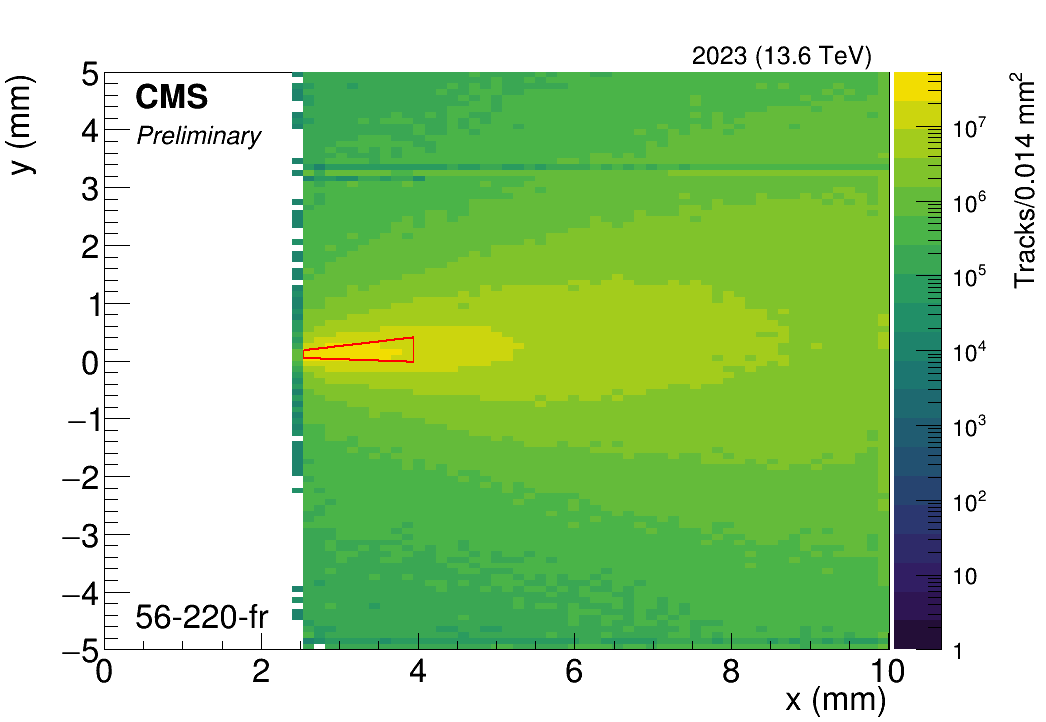

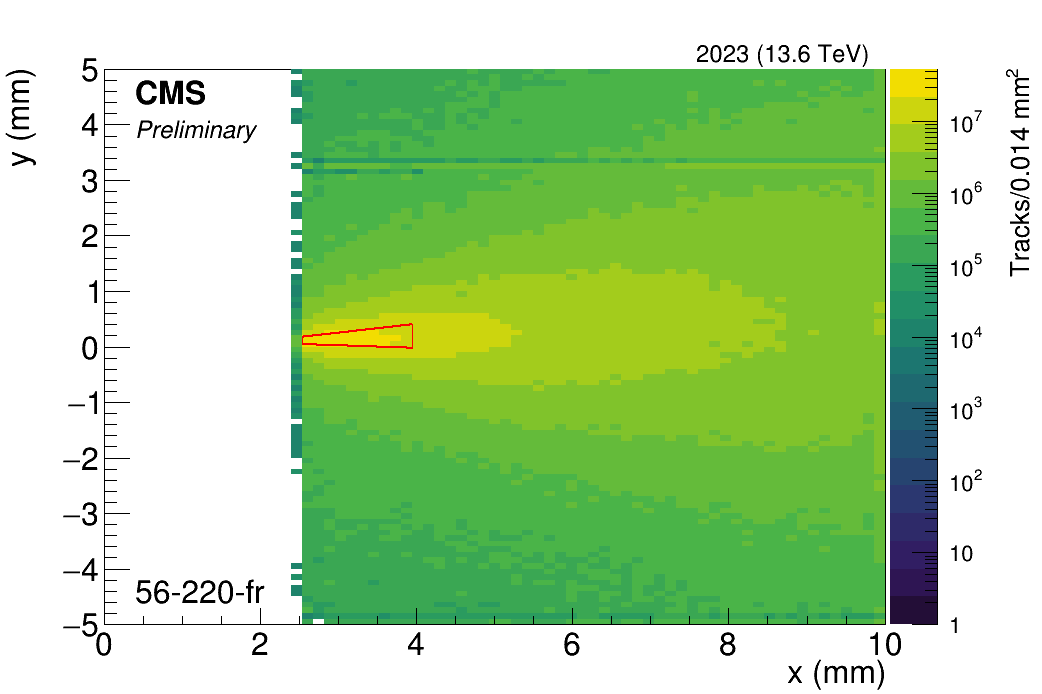

In [6]:
sector = '56'
station = '2'
n_sigma = 0.5

track_distribution_pattern = 'DQMData/Run 999999/Arm{arm}/Run summary/st{station}/rp3/h2TrackHitDistribution_arm{arm}_st{station}_rp3'
track_hist = utils.getPlot(track_dist_file_first,sector,station,track_distribution_pattern)
st_m = '220' if station == '2' else '210'
peak_points,beam_axis_points,max_vs_x,beam_axis,sigma_vs_x,canvas = fitDistribution(track_hist,0)
x_min_area,x_max_area = findXRange(peak_points,max_vs_x,0.7)

p_0_up = (
    x_min_area,
    beam_axis.Eval(x_min_area)+n_sigma*sigma_vs_x.Eval(x_min_area)
)
p_1_up = (
    x_max_area,
    beam_axis.Eval(x_max_area)+n_sigma*sigma_vs_x.Eval(x_max_area)
)
p_0_down = (
    x_min_area,
    beam_axis.Eval(x_min_area)-n_sigma*sigma_vs_x.Eval(x_min_area)
)
p_1_down = (
    x_max_area,
    beam_axis.Eval(x_max_area)-n_sigma*sigma_vs_x.Eval(x_max_area)
)

line_up = ROOT.TF1('line_up','pol1',x_min_area,x_max_area)
m_up = (p_1_up[1]-p_0_up[1])/(p_1_up[0]-p_0_up[0])
line_up.SetParameters(
    p_0_up[1]-p_0_up[0]*m_up,
    m_up
)

line_down = ROOT.TF1('line_down','pol2',x_min_area,x_max_area)
m_down = (p_1_down[1]-p_0_down[1])/(p_1_down[0]-p_0_down[0])
line_down.SetParameters(
    p_0_down[1]-p_0_down[0]*m_down,
    m_down
)

line_left = ROOT.TLine(x_min_area,line_down.Eval(x_min_area),x_min_area,line_up.Eval(x_min_area))
line_left.SetLineColor(ROOT.kRed)
line_right = ROOT.TLine(x_max_area,line_down.Eval(x_max_area),x_max_area,line_up.Eval(x_max_area))
line_right.SetLineColor(ROOT.kRed)

right_margin = 0.15
enlarge_factor = 1.5
c_hist_area = ROOT.TCanvas('c','c',round(700*enlarge_factor),round(500*enlarge_factor))
c_hist_area.SetRightMargin(right_margin)
ROOT.gStyle.SetPalette(ROOT.kViridis)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c_hist_area.SetLogz()

track_hist.GetXaxis().SetRangeUser(0,10)
track_hist.GetYaxis().SetRangeUser(-5,5)
track_hist.GetXaxis().SetTitleSize(0.05)
track_hist.GetXaxis().SetLabelSize(0.05)
track_hist.GetXaxis().SetTitleOffset(0.9)
track_hist.GetYaxis().SetTitleSize(0.05)
track_hist.GetYaxis().SetLabelSize(0.05)
track_hist.GetYaxis().SetTitleOffset(1)    
bin_area = track_hist.GetXaxis().GetBinWidth(1)*track_hist.GetYaxis().GetBinWidth(1)
track_hist.GetZaxis().SetTitle('Tracks/{bin_area:.3f} mm^{{2}}'.format(bin_area=bin_area))
track_hist.GetZaxis().SetTitleSize(0.04)
track_hist.GetZaxis().SetTitleOffset(1.2)
#track_hist.SetTitle('Track hit distribution - {sector}-{station}-fr'.format(sector=sector,station=st_m))

track_hist.DrawCopy('colz')
line_up.Draw('same')
line_down.Draw('same')
line_left.Draw('same')
line_right.Draw('same')

plotPubStatus = 'Preliminary'
cmsText = '#font[61]{CMS}'
cmsText2 = '#scale[0.76]{#font[52]{'+plotPubStatus+'}}'
stationTag = '#scale[1]{{#font[42]{{{sector}-{station}-fr}}}}'.format(sector=sector,station=st_m)
year_energy_tag = '#scale[0.76]{#font[42]{2023 (13.6 TeV)}}'
latex = ROOT.TLatex()
latex.SetTextSize(0.05)
latex.SetTextAlign(11)
latex.DrawLatexNDC(0.13,0.85,cmsText)
latex.DrawLatexNDC(0.13,0.80,cmsText2)
latex.DrawLatexNDC(0.13,0.13,stationTag)

latex.SetTextAlign(31)
latex.DrawLatexNDC(1-right_margin-0.01,0.91,year_energy_tag)

c_hist_area.DrawClone()
#c_hist_area.SaveAs('plots/AvgEfficiencyArea.png')
#canvas.DrawClone()

In [7]:
def avgEfficiency(run,min_x,max_x,line_down,line_up,sector,station):
    eff_file = rad_eff_file_pattern.format(run=run)
    rad_eff_pattern = 'DQMData/Run 999999/Run summary/h2RefinedTrackEfficiency_arm{arm}_st{station}_rp3'
    hist = utils.getPlot(eff_file,sector,station,rad_eff_pattern)
    n_bins_x = hist.GetXaxis().GetNbins()
    n_bins_y = hist.GetYaxis().GetNbins()
    eff_sum = 0
    eff_counts = 0
    for bin_x in range(1,n_bins_x + 1):
        for bin_y in range(1,n_bins_y + 1):
            x = hist.GetXaxis().GetBinCenter(bin_x)
            y = hist.GetYaxis().GetBinCenter(bin_y)
            if min_x < x < max_x and line_down.Eval(x) < y < line_up.Eval(x):
                bin_eff = hist.GetBinContent(bin_x,bin_y)
                eff_sum += bin_eff
                eff_counts += 1
    return eff_sum/eff_counts

In [8]:
## Tool for lumi
def fillDataFrame(csv_file):
    # Initialize empty lists for each column
    runs = []
    fills = []
    LSs = []
    dates = []
    del_lumis = []
    rec_lumis = []
    
    print('Parsing',csv_file+'...')
    # Open the CSV file for reading
    with open(csv_file, 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Check if the line does not start with '#'
            if not line.startswith('#'):
                # Split the line by commas
                parts = line.strip().split(',')

                # Extract the relevant information and append to the respective lists
                run_fill = parts[0].split(':')
                runs.append(int(run_fill[0]))
                fills.append(int(run_fill[1]))
                LSs.append(int(parts[1].split(':')[1]))
                dates.append(parts[2])
                del_lumis.append(float(parts[5]))
                rec_lumis.append(float(parts[6]))

    # Create a Pandas DataFrame from the lists
    df = pd.DataFrame({
        'run': runs,
        'fill': fills,
        'LS': LSs,
        'date': dates,
        'del_lumi': del_lumis,
        'rec_lumi': rec_lumis
    })

    # Add a cumulative sum column for del_lumi
    df['integrated_del_lumi'] = df['del_lumi'].cumsum()
    df['integrated_rec_lumi'] = df['rec_lumi'].cumsum()
    df['date'] = pd.to_datetime(df['date'])

    return df

pps_2023_track_csv = '../data/pps_track_only_2023.csv'
pps_2023_track_df = fillDataFrame(pps_2023_track_csv)

Parsing ../data/pps_track_only_2023.csv...


In [9]:
intLumis = []
avgEfficiencies = []
for run in runs:
    try:
        intLumis.append(float(pps_2023_track_df[pps_2023_track_df['run'] == run].iloc[[0]]['integrated_del_lumi']))
    except IndexError as e:
        continue
    avgEfficiencies.append(avgEfficiency(run,x_min_area,x_max_area,line_down,line_up,'56','2'))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file plots/Eff_vs_lumi_56_220.png has been created


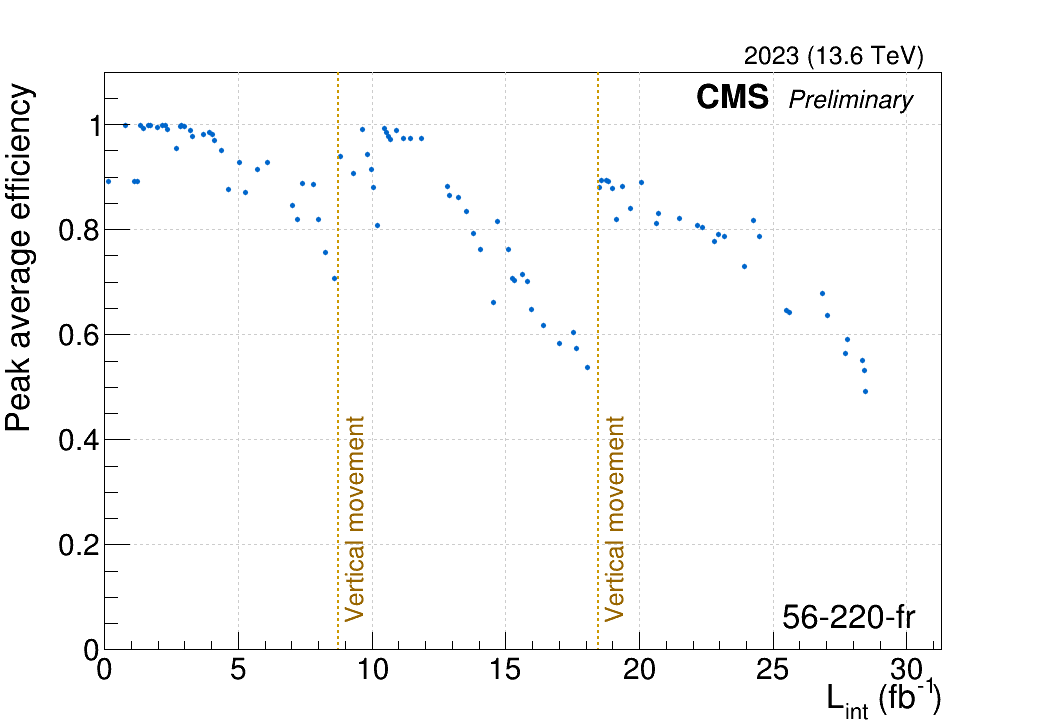

In [11]:
enlarge_factor = 1.5
c_avg_eff = ROOT.TCanvas('c','c',round(700*enlarge_factor),round(500*enlarge_factor))
g_avg_eff = ROOT.TGraph(len(intLumis))
for i in range(len(intLumis)):
    g_avg_eff.SetPoint(i,intLumis[i],avgEfficiencies[i])

g_avg_eff.SetTitle(';L_{{int}} (fb^{{-1}});Peak average efficiency'.format(sector=sector,station=st_m))
g_avg_eff.SetMarkerStyle(20)
g_avg_eff.SetMarkerSize(0.5)
g_avg_eff.GetYaxis().SetRangeUser(0,1.1)
g_avg_eff.SetLineColor(ROOT.kBlue)
g_avg_eff.SetMarkerColor(ROOT.kAzure+2)

g_avg_eff.GetXaxis().SetTitleSize(0.05)
g_avg_eff.GetXaxis().SetLabelSize(0.045)
g_avg_eff.GetXaxis().SetTitleOffset(0.85)
g_avg_eff.GetYaxis().SetTitleSize(0.05)
g_avg_eff.GetYaxis().SetLabelSize(0.045)
g_avg_eff.GetYaxis().SetTitleOffset(1)

plotPubStatus = 'Preliminary'
cmsText = '#font[61]{CMS} #scale[0.76]{#font[52]{'+plotPubStatus+'}}'
stationTag = '#scale[1]{{#font[42]{{{sector}-{station}-fr}}}}'.format(sector=sector,station=st_m)
year_energy_tag = '#scale[0.76]{#font[42]{2023 (13.6 TeV)}}'

latex = ROOT.TLatex()
latex.SetTextAlign(31)

c_avg_eff.SetGrid()
ROOT.gStyle.SetGridStyle(2)
ROOT.gStyle.SetGridColor(ROOT.kGray)
ROOT.gStyle.SetTitleFontSize(0.06)

g_avg_eff.Draw('AP')
latex.DrawLatexNDC(0.88,0.85,cmsText)
latex.DrawLatexNDC(0.88,0.13,stationTag)
latex.SetTextAlign(31)
latex.DrawLatexNDC(1-0.1-0.01,0.91,year_energy_tag)


lumi_first_movement = float(pps_2023_track_df[pps_2023_track_df['run'] == 367881].iloc[[0]]['integrated_del_lumi'])
lumi_second_movement = float(pps_2023_track_df[pps_2023_track_df['run'] == 369927].iloc[[0]]['integrated_del_lumi'])

line_first_movement = ROOT.TLine(lumi_first_movement,0,lumi_first_movement,1.1)
line_first_movement.SetLineColor(ROOT.kOrange-1)
line_first_movement.SetLineWidth(2)
line_first_movement.SetLineStyle(2)
line_first_movement.Draw('same')
latex.SetTextAlign(13)
latex.SetTextAngle(90)
latex.SetTextColor(ROOT.kOrange-6)
latex.DrawLatex(lumi_first_movement+0.2,0.05,'#scale[0.76]{#font[42]{Vertical movement}}')

line_second_movement = ROOT.TLine(lumi_second_movement,0,lumi_second_movement,1.1)
line_second_movement.SetLineColor(ROOT.kOrange-1)
line_second_movement.SetLineWidth(2)
line_second_movement.SetLineStyle(2)
line_second_movement.Draw('same')
latex.SetTextColor(ROOT.kOrange-6)
latex.DrawLatex(lumi_second_movement+0.2,0.05,'#scale[0.76]{#font[42]{Vertical movement}}')

c_avg_eff.Draw()
c_avg_eff.RedrawAxis()
c_avg_eff.SaveAs('plots/Eff_vs_lumi_{sector}_{station}.png'.format(sector=sector,station=st_m))
